In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Extract MNIST data</h2>
<p style="font-size:20px">You can change the option of one_hot encoding.

In [30]:
#get mnist data, with one_hot encoding
mnist = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(train_images, train_labels), (test_images, test_labels) = mnist

train_images = train_images.astype("float32")/255.0
test_images = test_images.astype("float32")/255.0
train_labels = tf.one_hot(train_labels,depth=10)
test_labels = tf.one_hot(test_labels, depth=10)

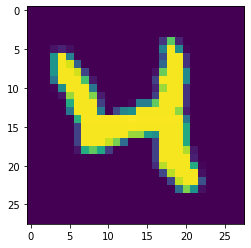

In [3]:
plt.figure()
plt.imshow(train_images[20])
plt.grid(False)
plt.show()

<h2>Define hyperparameters</h2>

In [4]:
NUM_ITER = 100
lr = 0.01
batch_size = 64
num_input = 784
n_hidden_1 = 100
n_hidden_2 = 100
num_classes = 10

<h2>Define placeholder and Variables</h2>

In [39]:
def mnist_model(hp):
    """
    define hp tune
    """
    activation = hp.Choice("activation", values=['relu', 'tanh', 'sigmoid', "softmax"])

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    for i in range(hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=16, max_value=256, step=16),
                activation=activation,
            )
        )
    model.add(keras.layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1.0, 1e-2, 1e-3, 1e-4])),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    return model

<h2>Define tuner</h2>

In [40]:
tuner = kt.RandomSearch(
    mnist_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="test_tune_0",
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'softmax'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 1.0, 'conditions': [], 'values': [1.0, 0.01, 0.001, 0.0001], 'ordered': True}


In [32]:
#START TUNING
tuner.search(train_images, train_labels, epochs=3, validation_split=0.1)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 00m 41s]
val_accuracy: 0.9769583344459534

Best val_accuracy So Far: 0.9769583344459534
Total elapsed time: 01h 06m 23s
INFO:tensorflow:Oracle triggered exit


KeyError: 'units does not exist.'

<h2>Define cost function and accuracy</h2>

<h2>Execute training</h2>

In [33]:
best_model = tuner.get_best_models()[0]
best_model.build(train_images.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 208)               163280    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6688      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 170,298
Trainable params: 170,298
Non-trainable params: 0
_________________________________________________________________


<h2>Your results</h2>